### Methodology Followed:

**OverView:**
- ACRONYMS : 
    - **UBLR** : Univariate binary logistic regression
    - **MBLR** : Multivariate binary logistic regression.
<br><br>
- METHODOLOGY :
    - **UBLR of metrics versus faults** : Determine which metrics are statistically significant.
    - **Collinearity analysis** : Determine which metrics to include in the model.
    - **Develop the model** : If time permits.



# 1. Data Preparation
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

data_V8  = pd.read_csv('data/v8.2.1.csv');
data_v10 = pd.read_csv('data/v10.0.csv');
data_v12 = pd.read_csv('data/v12.0.csv');
data_v14 = pd.read_csv('data/wildflyv14.0.1.csv');
data_v16 = pd.read_csv('data/wildfly.v16.0.csv');

dataSets = {
    'v8':data_V8,
    'v10':data_v10,
    'v12':data_v12,
    'v14':data_v14,
    'v16':data_v16,
}

Studied in class:
wmc
dit
noc
cbo
rfc
lcom

extra
nloc
sloc
cyclomatic


### Columns:
Renaming columns for readability and ease of use
- Kind : **kind**
- Name : **name**
- CountClassCoupled : **cbo**
- CountLineCode : **sloc**
- Cyclomatic : **cyclomatic (Cyclomatic Complexity)**
- MaxInheritanceTree : **dit**
- PercentLackOfCohesion : **lcom**
- SumCyclomatic : **wmc**

In [2]:
newColumns = ['kind','name','cbo','sloc','cyclomatic','dit','lcom','wmc'];

for dataset in dataSets:
    dataSets[dataset].columns = newColumns;
    dataSets[dataset] = dataSets[dataset].drop('kind',axis=1);
    dataSets[dataset] = dataSets[dataset].drop('name',axis=1);

---
# 2. Exploratory Data Analysis
---

### Exploring means for each attribute:

**Observations:**
- CBO : 
    - Dips from V8 to V12
    - slightly increases and remains steady for coming releases.
- WMC and Cyclomatic complexity : 
    - Drops steadily for each release
- SLOC : Here we can see an interesting pattern, 
    - Drops from V8 to V12, 
    - No changes are seen from V12 to V14
    - SLOC increase from V14 to V18
- DIT and LCOM : 
    - Here we can assume a corelation between these to metrics.
    - We can observe an inverse relationship between these metrics.

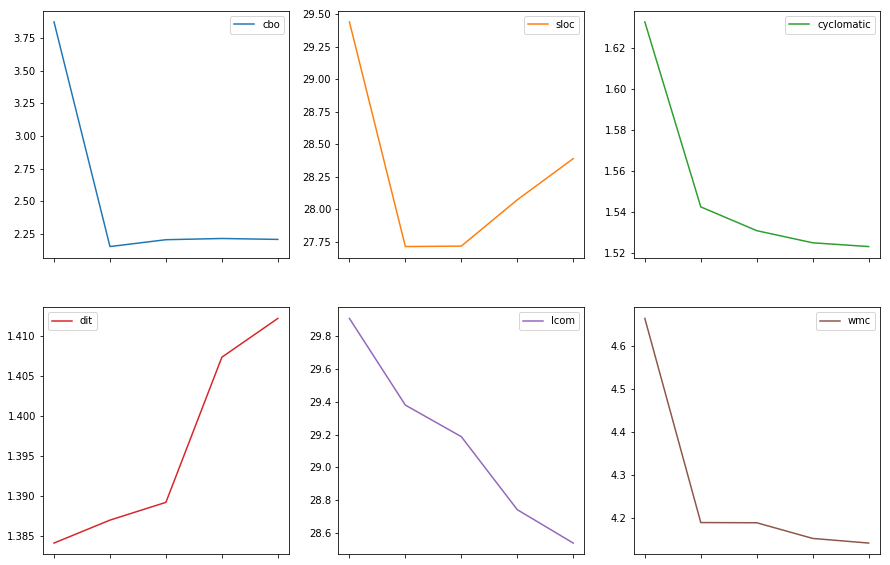

In [3]:
# ******************************* EXPLORING MEAN *******************************
def exploreMean(dataSets):
    meanDataset = pd.DataFrame();
    
    for dataset in dataSets:
        meanDataset[dataset] = dataSets[dataset].mean();
    return meanDataset.transpose();

means = exploreMean(dataSets)

f,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))
plot = means.plot(subplots=True,ax=ax);


---
### Exploring correlation among the metrics:
**Heatmap Observations:**
We Observe high correlation between:
- SLOC and WMC
- Cyclomatic and WMC

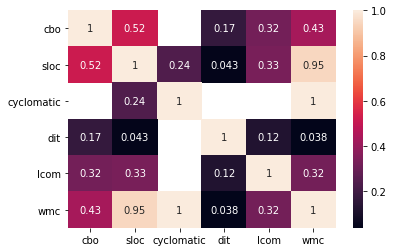

In [4]:
corr=data_V8.corr();
sns.heatmap(corr,annot=True)

---
**Helper Functions:**
- **getFaultBinary(dataFrame)** : 
    - uses bad smell criterias for binary classification
    - creates faultProne column (Binary)
    - counts bad smeels in dataset
- **getFaultyData( dataFrame, columname )**:
    - returns rows with faultProne=1
    
    
    
**METHODOLOGY**


In [5]:

# Manipulates dataset passed and returns
def getFaultBinaryDataset(dataSets=dict()):
    
    #applied on a single dataFrame
    def getFaultBinary(data = pd.DataFrame()):

        data['faultProne']=0;
        data['badSmells']=0;

        # applied to a row using lambda
        def binaryFaultProne(row):

            #Long Method
            if row.cyclomatic > 5:
                row['faultProne'] = 1
                row['badSmells']+=1
            #Large Class
            if row.dit > 5 :
                row['faultProne'] = 1
                row['badSmells']+=1
            #Feature Envy    
            if row.cbo > 5 :
                row['faultProne'] = 1
                row['badSmells']+=1
            #Data Class
            if row.lcom > 2 :
                row['faultProne'] = 1
                row['badSmells']+=1
            #Large Class
            if row.wmc > 10 :
                row['faultProne'] = 1
                row['badSmells']+=1

            return row


        return data.apply(lambda x:binaryFaultProne(x),axis=1);
    
    for version in dataSets:
        dataSets[version] = getFaultBinary(dataSets[version])
    
    return dataSets

In [6]:

## Manipulates passed dataset
## Returns dataset with faultProne == 1
def getFaultyDataset(binaryDataSets = dict(), col=''):
    
    def getFaultyData( bindaryDataframe = pd.DataFrame, col=''):    
        if (col==''):
            return bindaryDataframe[bindaryDataframe.faultProne==1];
        else:
            return bindaryDataframe[bindaryDataframe.faultProne==1][bindaryDataframe[col].isnull()==False]

    
    faultyDataset = dict();
    for version in binaryDataSets:
        faultyDataset[version] = getFaultyData(binaryDataSets[version],col);
    
    return faultyDataset;

In [7]:
def getBadSmellCountDf(dataSets):
    countdataSets = pd.Series()
    
    for version in dataSets:
        countdataSets[version] = dataSets[version].badSmells.sum()
        
    return countdataSets

def getBadSmellClassCountDf(dataSets):
    countdataSets = pd.Series()
    
    for version in dataSets:
        countdataSets[version] = dataSets[version].faultProne.sum()
        
    return countdataSets

In [24]:
faultyBinaryDataset = getFaultBinaryDataset(dataSets)    
fbs = faultyBinaryDataset

### BadSmellCounts:


Bad Smell Count

v8     18937.0
v10    11161.0
v12    12509.0
v14    13123.0
v16    13364.0
dtype: float64


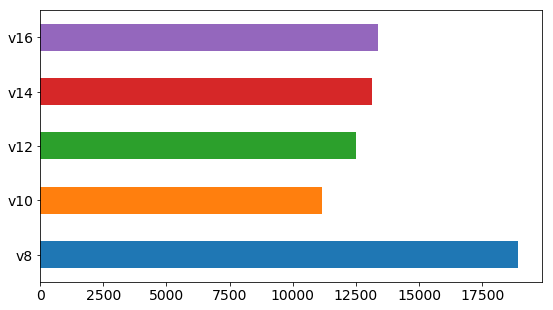

In [26]:
data = getBadSmellCountDf(faultyBinaryDataset)

plot = data.plot(kind='barh',label="ToalBadSmells",figsize=(9,5),fontsize=14)
print('\nBad Smell Count\n')
print(data)

### BadSmellClasses:


Classes with Bad Smell

v8     13562.0
v10     8697.0
v12     9784.0
v14    10264.0
v16    10462.0
dtype: float64


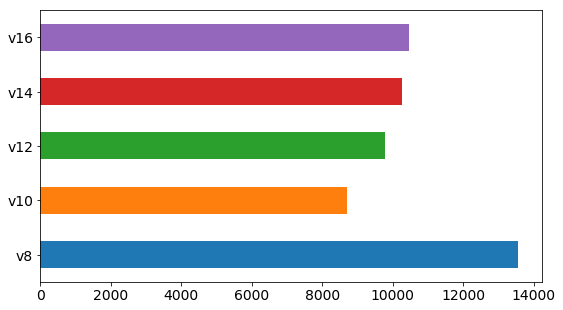

In [27]:
data = getBadSmellClassCountDf(faultyBinaryDataset)
plot = data.plot(kind='barh',label="ToalBadSmells",figsize=(9,5),fontsize=14)
print('\nClasses with Bad Smell\n')
print(data)

## Experiment with single dataset on faultproneness

In [34]:
def getFaultCountsVsMetric(faultyDataset):
    key = list(faultyDataset.keys())[0]
    columns = faultyDataset[key].columns
    metricColumns = columns[:5]
    countMetricFaultDataset = pd.DataFrame(columns=metricColumns)
    
    for version in faultyDataset:
        dataFrame = faultyDataset[version]
        
    return countMetricFaultDataset.columns

In [35]:
def getFaultCountsVsMetric(faultyDataset):
    metrics = faultyDataset[list(faultyDataset.keys())[0]].columns[:6]
    faultCountMetric = pd.DataFrame(columns=metrics,index=faultyDataset.keys())
    
    for version in faultyDataset:
        dataFrame = faultyDataset[version]
        for metric in metrics:
            faultCountMetric.loc[version][metric] = dataFrame[dataFrame[metric]==1]['faultProne'].sum() 
            
    return faultCountMetric

In [36]:
faultyDataset = getFaultyDataset(faultyBinaryDataset)

In [37]:
faultCountMetricData = getFaultCountsVsMetric(faultyDataset)

### Fault count VS Metrics For each release:
- cbo : number of faults increase with each release for cbo metric
- sloc : faults decrease
- cyclomatic : remains constant from v14
- dit : faults dip then increase with each release steadily

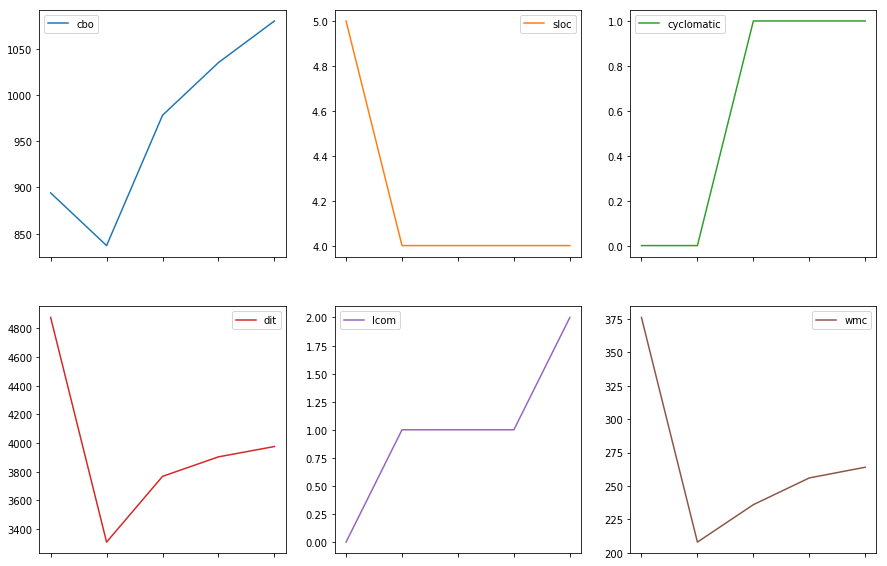

In [40]:
# Plotting counts of faults for each metric
f,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10),sharex=True)
for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(5))
plot = faultCountMetricData.plot(subplots=True,ax=ax,kind="line",use_index=True)

